In [21]:
import torch
import gpytorch
from math import pi
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

from tqdm.notebook import tqdm

## Use of mean function?
- Specifies Expected Functional Behavior
- for example: Zero mean (base strategy)(gpytorch.means.ZeroMean), Constant (gpytorch.means.ConstantMean), Linear, Quadratic or even custom

## Covariance Function: Defines Smoothness and Correlation
Controls function variability
- 1. Length scale: small → high variability; large → smoothness
- 2. Output scale: small → narrow output range; large → wide output range


# Defining the functional behavior of the mean function

In [2]:
xs = torch.linspace(0, 10, 101).unsqueeze(1)

train_x = torch.tensor([[0.5], [1.0], [1.5], [3], [4]])
train_y = torch.tensor([0.0625, 0.25, 0.375, 2.25, 4])

In [3]:
def visualize_gp_belief(model, likelihood):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )

    plt.legend(fontsize=15)

Using the zero mean function as the base strategy

In [4]:
class ConstantMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

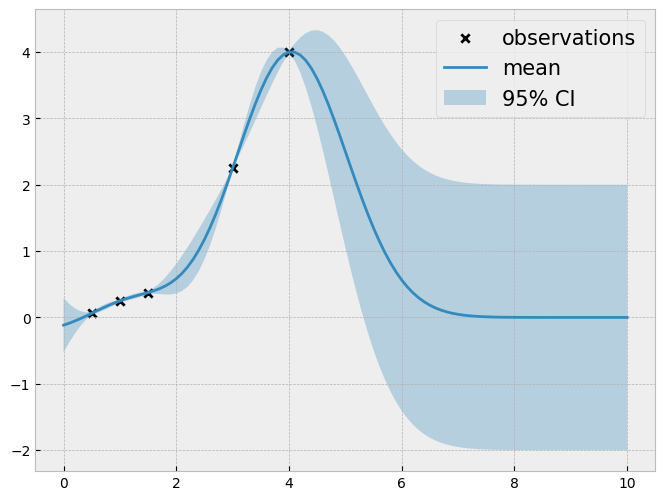

In [5]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ConstantMeanGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

 Using the constant function with gradient descent

The following line takes in a GP model and computes the marginal log likelihood of its training data
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

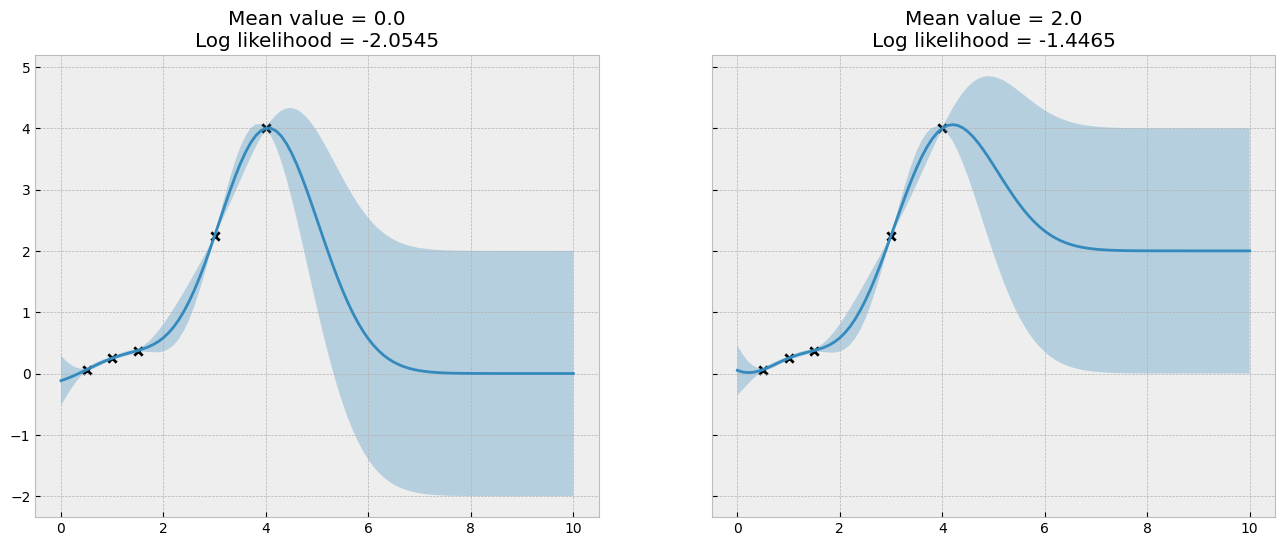

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# first panel
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_upper, predictive_lower = predictive_distribution.confidence_region()

ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

ax[0].plot(xs, predictive_mean, label="mean")
ax[0].fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95\% CI"
)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

with torch.no_grad():
    loss = -mll(model(train_x), train_y)

model.eval()
likelihood.eval()

ax[0].set_title(
    f"Mean value = {model.mean_module.constant.item():.1f}"
    + f"\nLog likelihood = {-loss.item():.4f}"
)

# second panel
model.mean_module.constant = 2  # torch.nn.Parameter(torch.tensor(2.0))

with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_upper, predictive_lower = predictive_distribution.confidence_region()

ax[1].scatter(train_x, train_y, marker="x", c="k", label="observations")

ax[1].plot(xs, predictive_mean, label="mean")
ax[1].fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95\% CI"
)

model.train()
likelihood.train()

with torch.no_grad():
    loss = -mll(model(train_x), train_y)

model.eval()
likelihood.eval()

ax[1].set_title(
    f"Mean value = {model.mean_module.constant.item():.1f}"
    + f"\nLog likelihood = {-loss.item():.4f}"
)

plt.show()

In [7]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ConstantMeanGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

 When we run the gradient descent procedure, the Adam algorithm iteratively updates the value of model.mean_module.constant to improve the likelihood function.

In [ ]:
# train the hyperparameter (the constant)

optimizer = torch.optim.Adam([model.mean_module.constant], lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
constants = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    constants.append(model.mean_module.constant.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

Running negative log likelihood (lower is better) and mean value during gradient descent. In both panels, the values have converged, indicating we have arrived at an optimum.

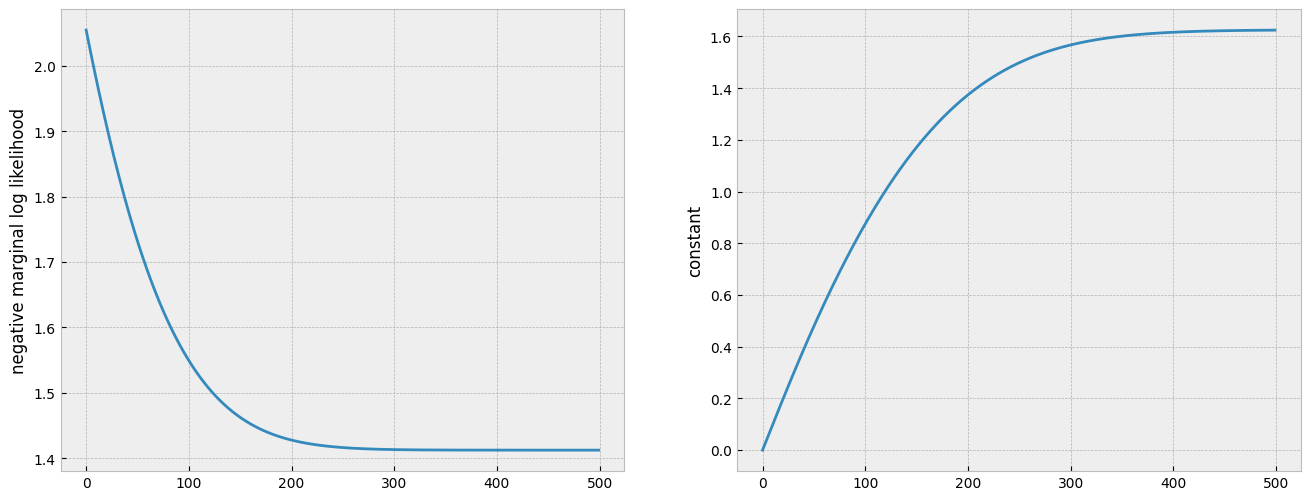

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(constants)
ax[1].set_ylabel("constant");

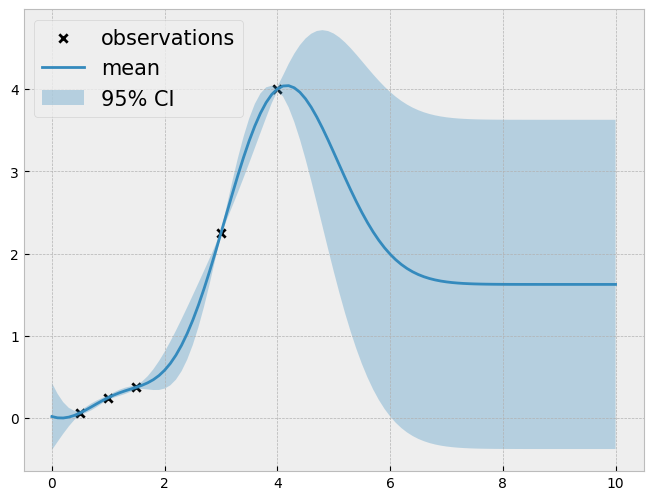

In [10]:
visualize_gp_belief(model, likelihood)

Using the linear function with gradient descent

In [11]:
class LinearMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(1)
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = LinearMeanGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

In [13]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.mean_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
weights = []
biases = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    weights.append(model.mean_module.weights.item())
    biases.append(model.mean_module.bias.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

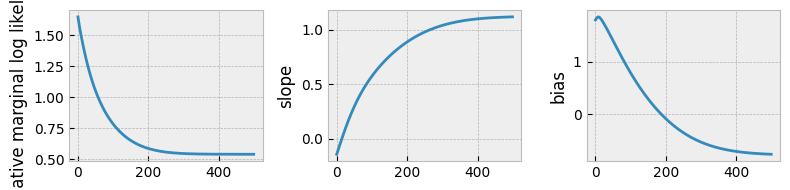

In [14]:

fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(weights)
ax[1].set_ylabel("slope")

ax[2].plot(biases)
ax[2].set_ylabel("bias")

plt.tight_layout();

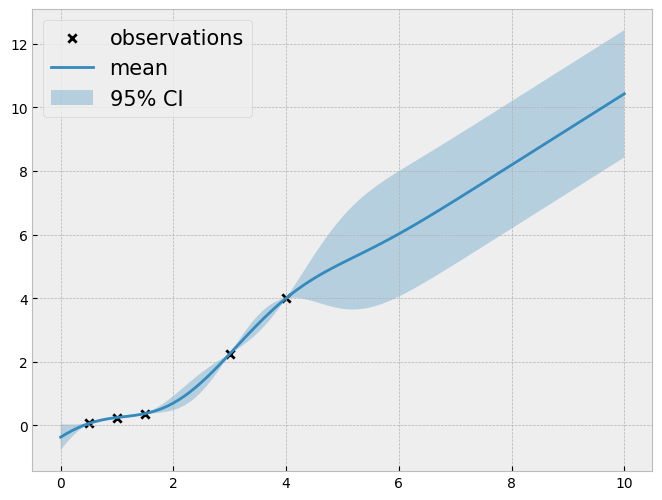

In [15]:
visualize_gp_belief(model, likelihood)


Using the quadratic function by implementing a custom mean function

In [16]:
class QuadraticMean(gpytorch.means.Mean):
    def __init__(self, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(
            name="second", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1, 1))
        )
        self.register_parameter(
            name="first", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1, 1))
        )

        if bias:
            self.register_parameter(
                name="bias", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
            )
        else:
            self.bias = None

    def forward(self, x):
        res = x.pow(2).matmul(self.second).squeeze(-1) + x.matmul(self.first).squeeze(
            -1
        )
        if self.bias is not None:
            res = res + self.bias
        return res


class QuadraticMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = QuadraticMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [17]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = QuadraticMeanGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

In [18]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.mean_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
firsts = []
seconds = []
biases = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    firsts.append(model.mean_module.first.item())
    seconds.append(model.mean_module.second.item())
    biases.append(model.mean_module.bias.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

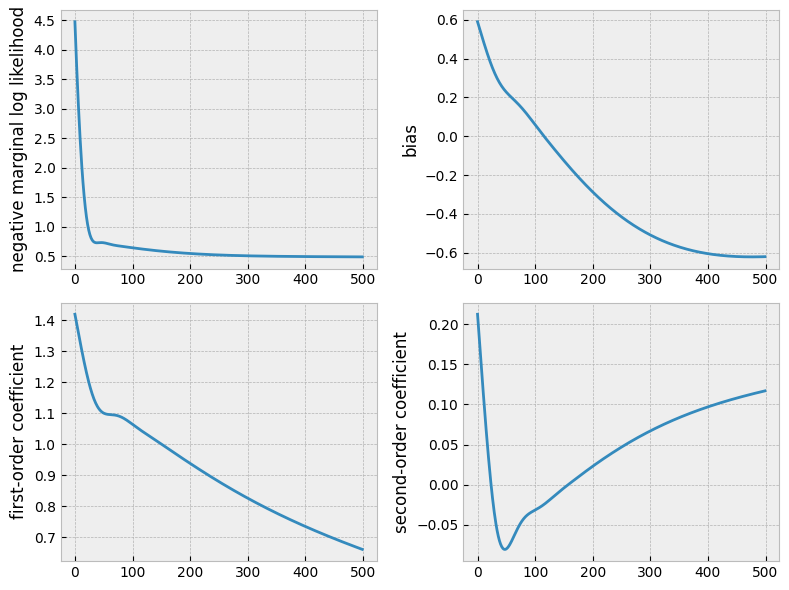

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0][0].plot(losses)
ax[0][0].set_ylabel("negative marginal log likelihood")

ax[0][1].plot(biases)
ax[0][1].set_ylabel("bias")

ax[1][0].plot(firsts)
ax[1][0].set_ylabel("first-order coefficient")

ax[1][1].plot(seconds)
ax[1][1].set_ylabel("second-order coefficient")

plt.tight_layout();

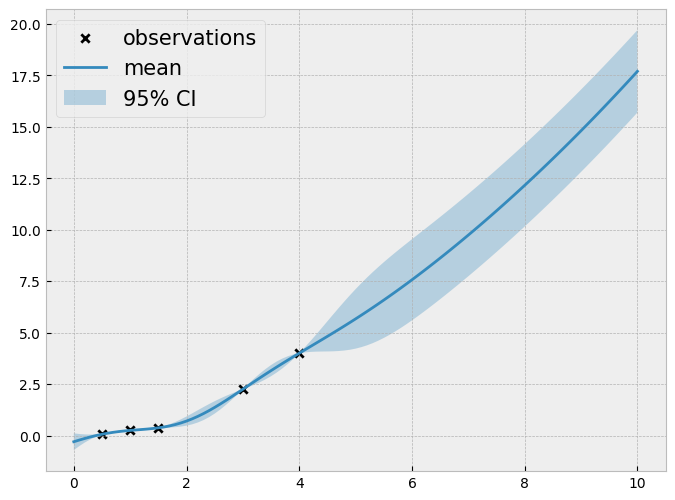

In [20]:
visualize_gp_belief(model, likelihood)

# Defining variability and smoothness with the covariance function

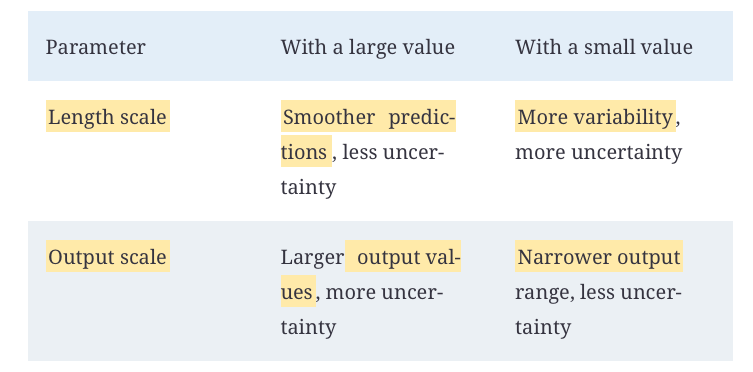

In [22]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief(model, likelihood, num_samples=5):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.plot(xs, ys, label="objective", c="r")
    plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )

    torch.manual_seed(0)
    for i in range(num_samples):
        plt.plot(xs, predictive_distribution.sample(), alpha=0.5, linewidth=2)

    plt.legend(fontsize=15)
    plt.show()

In [23]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(0)
train_x = torch.rand(size=(3, 1)) * 6 - 3
train_y = forrester_1d(train_x)

 Setting the scales of the covariance function

In [24]:
class ScaleGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

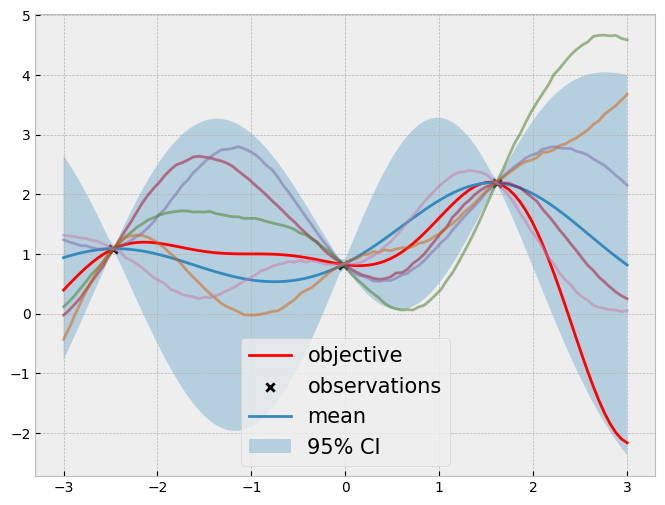

In [25]:
# declare the GP
lengthscale = 1  # 0.3, 1, 3
outputscale = 3  # 0.3, 1, 3
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ScaleGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

In [26]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.covar_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

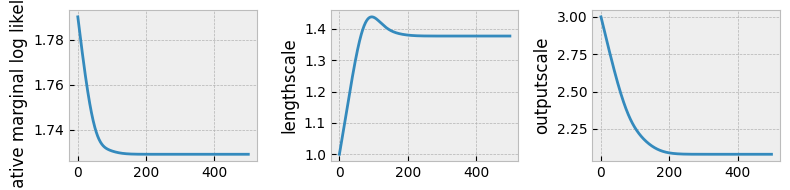

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale")

plt.tight_layout();

In [28]:
(
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item(),
)

(1.37723708152771, 2.079803466796875)

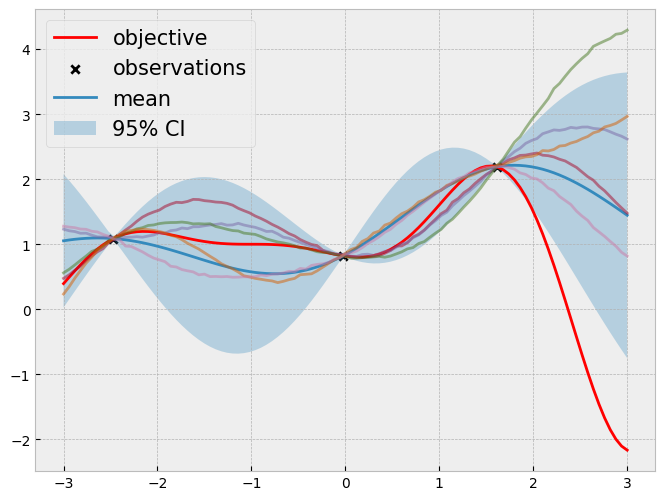

In [29]:
visualize_gp_belief(model, likelihood)

Controlling smoothness with different covariance functions

In [30]:

class RBFGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

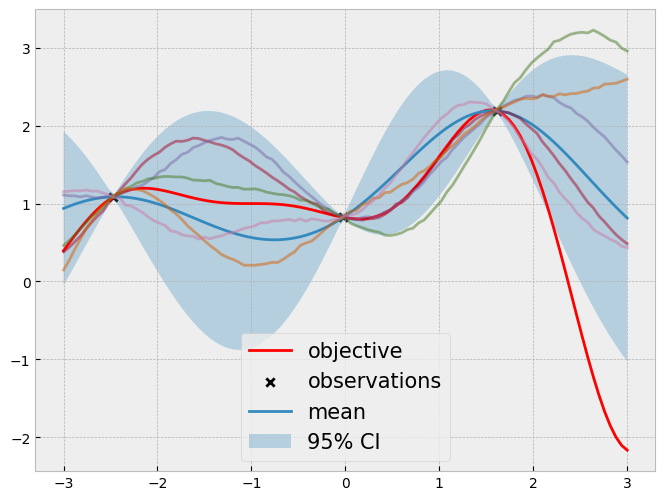

In [31]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RBFGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

In [32]:
class MaternGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

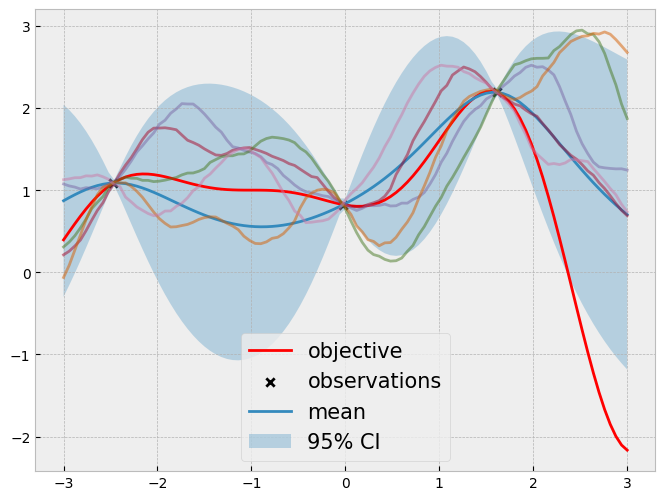

In [33]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MaternGPModel(train_x, train_y, likelihood, 2.5)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

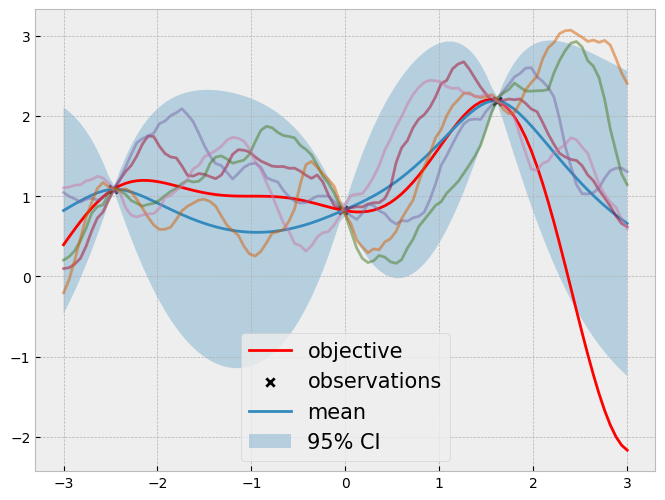

In [34]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MaternGPModel(train_x, train_y, likelihood, 1.5)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

Modeling different levels of variability with multiple length scales

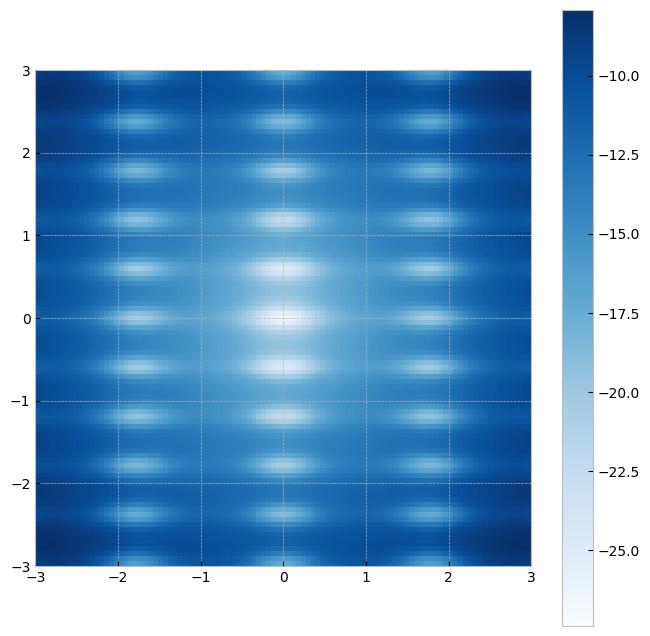

In [35]:
def ackley(x):
    # a modification of https://www.sfu.ca/~ssurjano/ackley.html
    return -20 * torch.exp(
        -0.2 * torch.sqrt((x[:, 0] ** 2 + x[:, 1] ** 2) / 2)
    ) - torch.exp(torch.cos(2 * pi * x[:, 0] / 3) + torch.cos(2 * pi * x[:, 1]))


xs = torch.linspace(-5, 5, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = ackley(xs)

plt.figure(figsize=(8, 8))

plt.imshow(ys.reshape(101, 101).T, origin="lower", extent=[-3, 3, -3, 3])
plt.colorbar();

In [36]:
torch.manual_seed(0)
train_x = torch.rand(size=(100, 2)) * 6 - 3
train_y = ackley(train_x)

In [37]:
class ARDGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [38]:
# declare the GP
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ARDGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.likelihood.noise = noise

# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
x_lengthscales = []
y_lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    x_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 0].item())
    y_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 1].item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

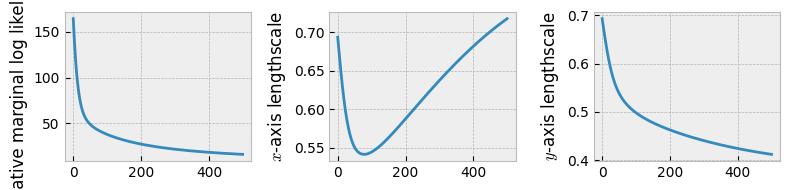

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(x_lengthscales)
ax[1].set_ylabel(r"$x$-axis lengthscale")

ax[2].plot(y_lengthscales)
ax[2].set_ylabel(r"$y$-axis lengthscale")

plt.tight_layout();

In [40]:

model.covar_module.base_kernel.lengthscale

tensor([[0.7175, 0.4117]], grad_fn=<SoftplusBackward0>)